[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ContextualAI/examples/blob/main/17-contextualai-chroma/03-contextual-ai-lmunit-chroma.ipynb)

# Natural Language Unit Testing for RAG Systems with Chroma and LMUnit

**Last updated:** November 2025

**Versions used:**
- Chroma version `1.3.4`
- Contextual AI client `0.9.0`

Evaluating LLM outputs in RAG systems is critical for ensuring response quality and reliability. This notebook demonstrates how to create and apply natural language unit tests using [LMUnit](https://contextual.ai/blog/lmunit/) with Chroma vector database for comprehensive RAG evaluation.

**Key Features:**
- **RAG Pipeline Evaluation**: Test complete Chroma + LLM RAG systems
- **Natural Language Unit Testing**: Systematic evaluation of response quality
- **Domain-Specific Testing**: Custom unit tests for different use cases
- **Visualization & Analysis**: Comprehensive evaluation results analysis

### Why Natural Language Unit Testing for RAG?

Traditional RAG evaluation methods often face several challenges:
- **Retrieval Quality**: Hard to measure if retrieved documents are relevant
- **Generation Quality**: LLM responses may be factually incorrect or poorly structured
- **End-to-End Evaluation**: Difficult to assess the complete RAG pipeline
- **Domain-Specific Requirements**: Generic metrics don't capture domain nuances

Natural language unit tests address these challenges by:
- **Breaking down evaluation** into specific, testable criteria
- **Providing granular feedback** on different quality aspects
- **Enabling systematic improvement** of RAG systems
- **Supporting domain-specific** quality requirements

**Open Source Alternative**: For users who want to host LMUnit themselves, we provide an open source version available on [Hugging Face](https://huggingface.co/collections/ContextualAI/lmunit).

To run this notebook, you'll need:
* A [Contextual AI API key](https://docs.contextual.ai/user-guides/beginner-guide) - for document parsing and content extraction.
Visit [app.contextual.ai](https://app.contextual.ai/?utm_campaign=chroma&utm_source=contextualai&utm_medium=github&utm_content=notebook) and click the **"Start Free"** button to sign up and receive free credits
* An [OpenAI API key](https://platform.openai.com/docs/quickstart) - for text embeddings


## Installation and Setup

First, let's install the required packages and set up our environment.


In [1]:
%%capture
%pip install --upgrade chromadb contextual-client openai requests rich pandas matplotlib seaborn scikit-learn tqdm

import warnings
warnings.filterwarnings("ignore")

import logging
# Suppress Chroma client logs
logging.getLogger("chromadb").setLevel(logging.ERROR)


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Union, Tuple
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from rich.console import Console
from rich.panel import Panel
from rich.table import Table

# Import Contextual AI and Chroma
from contextual import ContextualAI
import chromadb
from chromadb.utils import embedding_functions
from openai import OpenAI

print("All packages imported successfully!")


All packages imported successfully!


### API Keys Setup 🔑

We'll be using the Contextual AI API for LMUnit evaluation, OpenAI API for embeddings and generation, and Chroma for vector storage.


In [3]:
# API key variable names
contextual_api_key_var = "CONTEXTUAL_API_KEY"  # Replace with the name of your secret/env var
openai_api_key_var = "OPENAI_API_KEY"  # Replace with the name of your secret/env var

# Fetch API keys
try:
    # If running in Colab, fetch API keys from Secrets
    import google.colab
    from google.colab import userdata
    contextual_api_key = userdata.get(contextual_api_key_var)
    openai_api_key = userdata.get(openai_api_key_var)

    if not contextual_api_key:
        raise ValueError(f"Secret '{contextual_api_key_var}' not found in Colab secrets.")
    if not openai_api_key:
        raise ValueError(f"Secret '{openai_api_key_var}' not found in Colab secrets.")
except ImportError:
    # If not running in Colab, fetch API keys from environment variables
    import os
    contextual_api_key = os.getenv(contextual_api_key_var)
    openai_api_key = os.getenv(openai_api_key_var)

    if not contextual_api_key:
        raise EnvironmentError(
            f"Environment variable '{contextual_api_key_var}' is not set. "
            "Please define it before running this script."
        )
    if not openai_api_key:
        raise EnvironmentError(
            f"Environment variable '{openai_api_key_var}' is not set. "
            "Please define it before running this script."
        )

print("API keys configured successfully!")


API keys configured successfully!


## Part 1: Setup Chroma with Sample Knowledge Base

Let's create a Chroma collection with sample enterprise documents to demonstrate RAG evaluation.


In [5]:
# Initialize clients
contextual_client = ContextualAI(api_key=contextual_api_key)
chroma_client = chromadb.Client()
openai_client = OpenAI(api_key=openai_api_key)

# Use OpenAI embeddings
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=openai_api_key,
    model_name="text-embedding-3-small"
)

# Create collection
collection_name = "enterprise_knowledge"
collection = chroma_client.get_or_create_collection(
    name=collection_name,
    embedding_function=openai_ef
)

print(f"Created collection '{collection_name}' with OpenAI embeddings")


Created collection 'enterprise_knowledge' with OpenAI embeddings


In [6]:
# Sample enterprise knowledge base documents
knowledge_documents = [
    {
        "content": "Our company's AI training infrastructure uses NVIDIA RTX 5090 GPUs with 128GB HBM3e memory. The system achieves 2.5x faster training performance compared to previous generation GPUs. Power consumption is 450W TDP with 20% cooling overhead. Enterprise pricing for bulk orders (100+ units) is $2,899 per unit.",
        "metadata": {
            "title": "AI Infrastructure Specifications",
            "department": "Engineering",
            "date": "2025-01-15",
            "classification": "Internal"
        }
    },
    {
        "content": "Customer service AI system handles 70% of inquiries without human intervention. Average response time is 30 seconds, increasing to 2 minutes during peak hours. The system excels at returns and order tracking but struggles with complex billing disputes. Success rate for basic inquiries is 85%.",
        "metadata": {
            "title": "Customer Service AI Performance",
            "department": "Customer Success",
            "date": "2025-01-10",
            "classification": "Internal"
        }
    },
    {
        "content": "Financial compliance requires all AI-generated responses to include risk disclaimers. Regulatory requirements mandate specific language for investment advice. All customer-facing AI must be audited quarterly for compliance with SEC regulations. Penalties for non-compliance can reach $1M per violation.",
        "metadata": {
            "title": "AI Compliance Requirements",
            "department": "Legal",
            "date": "2025-01-20",
            "classification": "Confidential"
        }
    },
    {
        "content": "Market analysis shows AI adoption increasing 40% year-over-year in enterprise sectors. Key trends include multimodal AI, edge computing, and responsible AI practices. Investment in AI infrastructure is expected to reach $200B by 2026. Competitive advantage requires continuous innovation in AI capabilities.",
        "metadata": {
            "title": "AI Market Trends Analysis",
            "department": "Research",
            "date": "2025-01-05",
            "classification": "Public"
        }
    },
    {
        "content": "Data privacy regulations require all AI systems to implement data minimization principles. Personal data processing must be limited to necessary purposes. Users have the right to data portability and deletion. AI systems must provide clear explanations of automated decisions affecting individuals.",
        "metadata": {
            "title": "AI Data Privacy Guidelines",
            "department": "Privacy",
            "date": "2025-01-12",
            "classification": "Confidential"
        }
    }
]

# Add documents to Chroma
documents = [doc["content"] for doc in knowledge_documents]
metadatas = [doc["metadata"] for doc in knowledge_documents]
ids = [f"doc_{i}" for i in range(len(knowledge_documents))]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

print(f"Added {len(knowledge_documents)} documents to Chroma collection")


Added 5 documents to Chroma collection


## Part 2: RAG Pipeline and Test Queries

Let's create a complete RAG pipeline and generate responses for evaluation.


In [7]:
def rag_pipeline(query, top_k=3):
    """
    Complete RAG pipeline: Chroma retrieval + LLM generation
    """
    # Step 1: Retrieve from Chroma
    results = collection.query(
        query_texts=[query],
        n_results=top_k,
        include=["documents", "metadatas", "distances"]
    )

    # Step 2: Prepare context
    context_docs = results['documents'][0]
    context_metadata = results['metadatas'][0]

    # Combine context with metadata
    context = "\n\n".join([
        f"Source: {meta['title']} ({meta['department']})\n{doc}"
        for doc, meta in zip(context_docs, context_metadata)
    ])

    # Step 3: Generate response with LLM
    response = openai_client.chat.completions.create(
        model="gpt-5-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context. Use only the information from the context and cite your sources."},
            {"role": "user", "content": f"Context: {context}\n\nQuestion: {query}"}
        ],
        temperature=1
    )

    return {
        "query": query,
        "response": response.choices[0].message.content,
        "sources": context_metadata,
        "context": context
    }

# Test queries for evaluation
test_queries = [
    "What are the technical specifications of our AI infrastructure?",
    "How well does our customer service AI perform?",
    "What compliance requirements do we need to follow for AI systems?",
    "What are the current market trends in AI adoption?",
    "What privacy guidelines must our AI systems follow?"
]

print(f"Created {len(test_queries)} test queries for RAG evaluation")


Created 5 test queries for RAG evaluation


In [8]:
# Generate RAG responses for all test queries
console = Console()
console.print(Panel("🚀 GENERATING RAG RESPONSES", style="bold magenta"))

rag_results = []
for i, query in enumerate(test_queries):
    console.print(f"Processing query {i+1}/{len(test_queries)}: {query}")
    result = rag_pipeline(query)
    rag_results.append(result)
    console.print(f"Generated response: {result['response'][:100]}...")
    console.print("")

console.print(Panel(f"Generated {len(rag_results)} RAG responses for evaluation", style="bold green"))


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 GENERATING RAG RESPONSES                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Processing query 1/5: What are the technical specifications of our AI infrastructure?

Generated response: - GPU: NVIDIA RTX 5090 (128 GB HBM3e memory) (Source: AI Infrastructure Specifications 
(Engineering)...

Processing query 2/5: How well does our customer service AI perform?

Generated response: Summary: Overall performance is solid for routine customer requests but limited on complex 
billing i...

Processing query 3/5: What compliance requirements do we need to follow for AI systems?

Generated response: Summary of compliance requirements

Legal / Financial
- All AI-generated responses must include risk...

Processing query 4/5: What are the current market trends in AI adoption?

Generated response: Current market trends in AI adoption

- Rapid enterprise adoption: AI adoption is increasing ~40% ye...

Processing query 5/5: What privacy guidelines must our AI systems follow?

Generated response: Our AI systems must follow these privacy requirements (from AI Data Privacy Guidelines 
(Privacy)):

...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Generated 5 RAG responses for evaluation                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Part 3: Natural Language Unit Testing with LMUnit

Now let's define unit tests and evaluate our RAG responses using Contextual AI's LMUnit.


In [9]:
# Define unit tests for RAG evaluation
unit_tests = [
    "Does the response accurately reflect the information from the retrieved context?",
    "Is the response clear and well-structured for the target audience?",
    "Does the response provide specific details and avoid vague statements?",
    "Are potential risks or limitations mentioned when relevant?",
    "Does the response cite or reference the source information appropriately?",
    "Is the response actionable and provide clear next steps or implications?"
]

print("Unit Tests for RAG Evaluation:")
for i, test in enumerate(unit_tests, 1):
    print(f"{i}. {test}")


Unit Tests for RAG Evaluation:
1. Does the response accurately reflect the information from the retrieved context?
2. Is the response clear and well-structured for the target audience?
3. Does the response provide specific details and avoid vague statements?
4. Are potential risks or limitations mentioned when relevant?
5. Does the response cite or reference the source information appropriately?
6. Is the response actionable and provide clear next steps or implications?


In [10]:
def run_lmunit_evaluation(rag_results, unit_tests):
    """
    Run LMUnit evaluation on RAG responses
    """
    console = Console()
    console.print(Panel("🧪 RUNNING LMUNIT EVALUATION", style="bold blue"))

    evaluation_results = []

    for i, result in enumerate(tqdm(rag_results, desc="Evaluating responses")):
        console.print(f"\nEvaluating response {i+1}/{len(rag_results)}")
        console.print(f"Query: {result['query']}")

        response_tests = []

        for j, test in enumerate(unit_tests):
            try:
                # Run LMUnit evaluation
                lmunit_result = contextual_client.lmunit.create(
                    query=result['query'],
                    response=result['response'],
                    unit_test=test
                )

                score_value = getattr(lmunit_result, 'score', None)
                response_tests.append({
                    'test': test,
                    'score': score_value,
                    'evaluation': None
                })

                if score_value is not None:
                    console.print(f"  Test {j+1}: Score {score_value:.2f}")
                else:
                    console.print(f"  Test {j+1}: No score returned")

            except Exception as e:
                error_message = str(e)
                try:
                    import json as _json
                    parsed = _json.loads(error_message) if isinstance(error_message, str) else None
                    if isinstance(parsed, dict) and 'detail' in parsed and isinstance(parsed['detail'], list):
                        msgs = "; ".join([item.get('msg', '') for item in parsed['detail'] if isinstance(item, dict)])
                        if msgs:
                            error_message = msgs
                except Exception:
                    pass
                console.print(f"  Test {j+1}: Error - {error_message}")
                response_tests.append({
                    'test': test,
                    'score': None,
                    'error': error_message
                })

        evaluation_results.append({
            'query': result['query'],
            'response': result['response'],
            'sources': result['sources'],
            'test_results': response_tests
        })

    return evaluation_results

# Run the evaluation
evaluation_results = run_lmunit_evaluation(rag_results, unit_tests)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🧪 RUNNING LMUNIT EVALUATION                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Evaluating responses:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating response 1/5

Query: What are the technical specifications of our AI infrastructure?

Test 1: Score 3.95

Test 2: Score 4.24

Test 3: Score 4.81

Test 4: Score 1.57

Test 5: Score 4.68

Test 6: Score 2.35

Evaluating responses:  20%|██        | 1/5 [00:08<00:34,  8.54s/it]

Evaluating response 2/5

Query: How well does our customer service AI perform?

Test 1: Score 4.23

Test 2: Score 4.49

Test 3: Score 4.88

Test 4: Score 4.92

Test 5: Score 4.76

Test 6: Score 4.21

Evaluating responses:  40%|████      | 2/5 [00:18<00:27,  9.08s/it]

Evaluating response 3/5

Query: What compliance requirements do we need to follow for AI systems?

Test 1: Score 3.82

Test 2: Score 4.30

Test 3: Score 4.49

Test 4: Score 3.92

Test 5: Score 3.83

Test 6: Score 4.30

Evaluating responses:  60%|██████    | 3/5 [00:27<00:18,  9.40s/it]

Evaluating response 4/5

Query: What are the current market trends in AI adoption?

Test 1: Score 3.77

Test 2: Score 4.06

Test 3: Score 4.62

Test 4: Score 4.04

Test 5: Score 3.94

Test 6: Score 2.92

Evaluating responses:  80%|████████  | 4/5 [00:37<00:09,  9.45s/it]

Evaluating response 5/5

Query: What privacy guidelines must our AI systems follow?

Test 1: Score 4.50

Test 2: Score 4.39

Test 3: Score 4.54

Test 4: Score 2.09

Test 5: Score 4.46

Test 6: Score 3.82

Evaluating responses: 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]


## Part 4: Analysis and Visualization

Let's analyze the evaluation results and create visualizations to understand RAG performance.


In [11]:
# Create evaluation summary
def create_evaluation_summary(evaluation_results):
    """
    Create a summary of evaluation results
    """
    console = Console()

    # Calculate overall statistics
    all_scores = []
    test_names = []

    for result in evaluation_results:
        for test_result in result['test_results']:
            if test_result['score'] is not None:
                all_scores.append(test_result['score'])
                test_names.append(test_result['test'])

    if all_scores:
        avg_score = np.mean(all_scores)
        min_score = np.min(all_scores)
        max_score = np.max(all_scores)

        console.print(Panel(f"""
📊 EVALUATION SUMMARY

Total Tests: {len(all_scores)}
Average Score: {avg_score:.2f}/5.0
Score Range: {min_score:.2f} - {max_score:.2f}
Responses Evaluated: {len(evaluation_results)}
        """, title="LMUnit Evaluation Results", border_style="bold green"))

    return all_scores, test_names

# Generate summary
all_scores, test_names = create_evaluation_summary(evaluation_results)


╭─────────────────────────────────────────── LMUnit Evaluation Results ───────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 EVALUATION SUMMARY                                                                                           │
│                                                                                                                 │
│ Total Tests: 30                                                                                                 │
│ Average Score: 4.03/5.0                                                                                         │
│ Score Range: 1.57 - 4.92                                                                                        │
│ Responses Evaluated: 5                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
# Create detailed results table
def create_results_table(evaluation_results):
    """
    Create a detailed results table
    """
    console = Console()

    table = Table(title="Detailed Evaluation Results")
    table.add_column("Query", style="cyan", no_wrap=True)
    table.add_column("Test", style="magenta")
    table.add_column("Score", style="green")
    table.add_column("Response Preview", style="yellow")

    for result in evaluation_results:
        query_short = result['query'][:50] + "..." if len(result['query']) > 50 else result['query']
        response_short = result['response'][:50] + "..." if len(result['response']) > 50 else result['response']

        for test_result in result['test_results']:
            if test_result['score'] is not None:
                test_short = test_result['test'][:40] + "..." if len(test_result['test']) > 40 else test_result['test']
                table.add_row(
                    query_short,
                    test_short,
                    f"{test_result['score']:.2f}",
                    response_short
                )

    console.print(table)

# Display results table
create_results_table(evaluation_results)


                                            Detailed Evaluation Results                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Query                                                 ┃ Test                   ┃ Score ┃ Response Preview       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ What are the technical specifications of our AI in... │ Does the response      │ 3.95  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ accurately reflect     │       │ (128 GB HBM3e memory)  │
│                                                       │ the...                 │       │ (Sour...               │
│ What are the technical specifications of our AI in... │ Is the response clear  │ 4.24  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ and well-structure...  │       │ (128 GB HBM3e memory)  │
│                                                       │                        │       │ (Sour...               │
│ What are the technical specifications of our AI in... │ Does the response      │ 4.81  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ provide specific       │       │ (128 GB HBM3e memory)  │
│                                                       │ detai...               │       │ (Sour...               │
│ What are the technical specifications of our AI in... │ Are potential risks or │ 1.57  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ limitations menti...   │       │ (128 GB HBM3e memory)  │
│                                                       │                        │       │ (Sour...               │
│ What are the technical specifications of our AI in... │ Does the response cite │ 4.68  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ or reference the ...   │       │ (128 GB HBM3e memory)  │
│                                                       │                        │       │ (Sour...               │
│ What are the technical specifications of our AI in... │ Is the response        │ 2.35  │ - GPU: NVIDIA RTX 5090 │
│                                                       │ actionable and provide │       │ (128 GB HBM3e memory)  │
│                                                       │ c...                   │       │ (Sour...               │
│ How well does our customer service AI perform?        │ Does the response      │ 4.23  │ Summary: Overall       │
│                                                       │ accurately reflect     │       │ performance is solid   │
│                                                       │ the...                 │       │ for routine ...        │
│ How well does our customer service AI perform?        │ Is the response clear  │ 4.49  │ Summary: Overall       │
│                                                       │ and well-structure...  │       │ performance is solid   │
│                                                       │                        │       │ for routine ...        │
│ How well does our customer service AI perform?        │ Does the response      │ 4.88  │ Summary: Overall       │
│                                                       │ provide specific       │       │ performance is solid   │
│                                                       │ detai...               │       │ for routine ...        │
│ How well does our customer service AI perform?        │ Are potential risks or │ 4.92  │ Summary: Overall       │
│                                                       │ limitations menti...   │       │ performance is solid   │
│                                                       │                        │       │ for routine ...        │
│ How well does our customer service AI perform?        

### Create Visualizations

We'll create comprehensive visualizations to analyze the evaluation results from multiple perspectives:

1. **Score Distribution**: Histogram showing the overall distribution of scores across all tests, helping identify if responses generally score high or low
2. **Average Score by Test**: Bar chart comparing performance across different unit tests, revealing which quality dimensions are strongest or weakest
3. **Average Score by Response**: Bar chart comparing overall performance of different RAG responses, identifying which queries produce better results
4. **Score Heatmap**: Matrix visualization showing scores for each test-response combination, enabling quick identification of patterns and outliers

These visualizations help identify areas for improvement in the RAG pipeline, whether it's specific quality dimensions that need attention or particular queries that generate lower-quality responses.


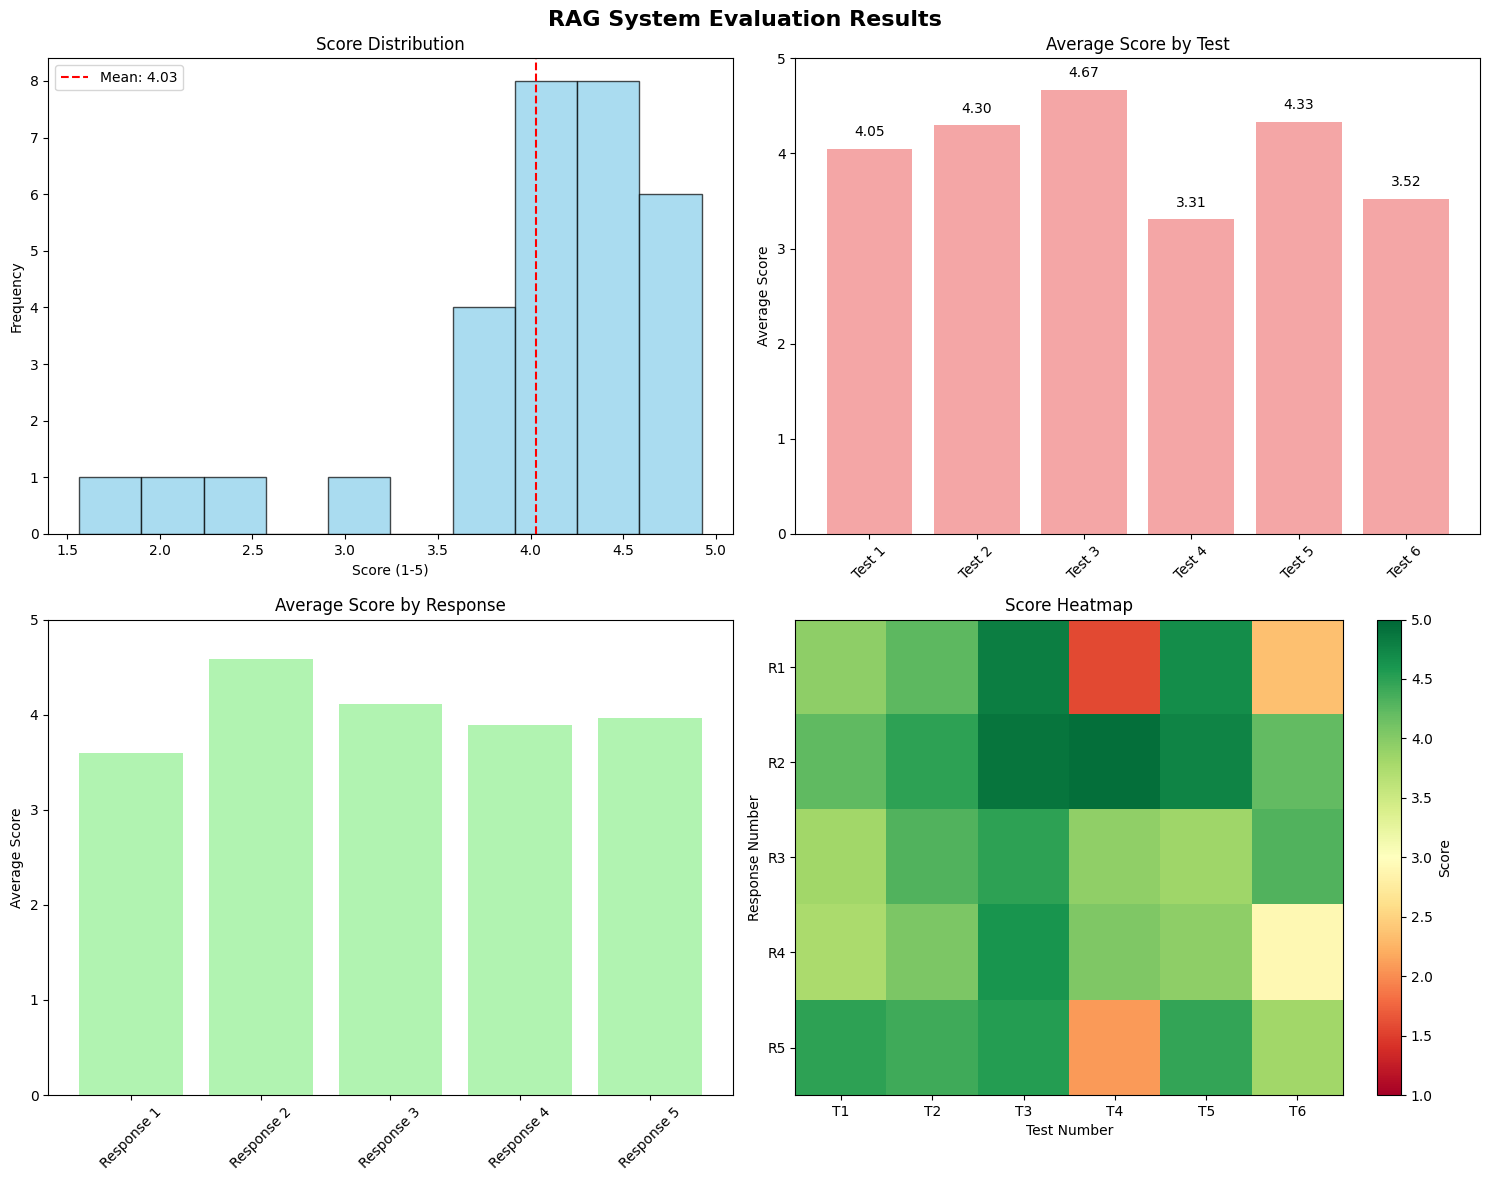

In [13]:
# Create visualizations
def create_evaluation_visualizations(evaluation_results, unit_tests):
    """
    Create visualizations for evaluation results
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')

    # 1. Score distribution histogram
    all_scores = []
    for result in evaluation_results:
        for test_result in result['test_results']:
            if test_result['score'] is not None:
                all_scores.append(test_result['score'])

    axes[0, 0].hist(all_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Score Distribution')
    axes[0, 0].set_xlabel('Score (1-5)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(np.mean(all_scores), color='red', linestyle='--', label=f'Mean: {np.mean(all_scores):.2f}')
    axes[0, 0].legend()

    # 2. Test performance comparison
    test_scores = {}
    for i, test in enumerate(unit_tests):
        test_scores[f"Test {i+1}"] = []
        for result in evaluation_results:
            if i < len(result['test_results']) and result['test_results'][i]['score'] is not None:
                test_scores[f"Test {i+1}"].append(result['test_results'][i]['score'])

    test_means = [np.mean(scores) if scores else 0 for scores in test_scores.values()]
    test_names = list(test_scores.keys())

    bars = axes[0, 1].bar(test_names, test_means, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Average Score by Test')
    axes[0, 1].set_ylabel('Average Score')
    axes[0, 1].set_ylim(0, 5)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, mean in zip(bars, test_means):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{mean:.2f}', ha='center', va='bottom')

    # 3. Response performance comparison
    response_scores = []
    response_names = []
    for i, result in enumerate(evaluation_results):
        scores = [test_result['score'] for test_result in result['test_results'] if test_result['score'] is not None]
        if scores:
            response_scores.append(np.mean(scores))
            response_names.append(f"Response {i+1}")

    axes[1, 0].bar(response_names, response_scores, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Average Score by Response')
    axes[1, 0].set_ylabel('Average Score')
    axes[1, 0].set_ylim(0, 5)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Score heatmap
    score_matrix = []
    for result in evaluation_results:
        row = []
        for test_result in result['test_results']:
            row.append(test_result['score'] if test_result['score'] is not None else 0)
        score_matrix.append(row)

    im = axes[1, 1].imshow(score_matrix, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)
    axes[1, 1].set_title('Score Heatmap')
    axes[1, 1].set_xlabel('Test Number')
    axes[1, 1].set_ylabel('Response Number')
    axes[1, 1].set_xticks(range(len(unit_tests)))
    axes[1, 1].set_yticks(range(len(evaluation_results)))
    axes[1, 1].set_xticklabels([f"T{i+1}" for i in range(len(unit_tests))])
    axes[1, 1].set_yticklabels([f"R{i+1}" for i in range(len(evaluation_results))])

    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 1])
    cbar.set_label('Score')

    plt.tight_layout()
    plt.show()

# Create visualizations
create_evaluation_visualizations(evaluation_results, unit_tests)


## Summary

This notebook demonstrates comprehensive RAG system evaluation using Chroma and Contextual AI's LMUnit for natural language unit testing.

### What We Demonstrated:

1. **Complete RAG Pipeline**: Chroma retrieval + LLM generation with enterprise knowledge base
2. **Natural Language Unit Testing**: Systematic evaluation using LMUnit with 6 quality dimensions
3. **Comprehensive Analysis**: Statistical analysis and visualization of evaluation results
4. **Production-Ready Evaluation**: Scalable approach for enterprise RAG systems

### Key Benefits of LMUnit for RAG Evaluation:

- **Granular Quality Assessment**: Break down response quality into specific, measurable criteria
- **Flexible Evaluation**: Users can fully customize the unit tests to match their specific requirements
- **Consistent Evaluation**: Standardized scoring across different responses and contexts
- **Actionable Insights**: Identify specific areas for RAG system improvement

### RAG Evaluation Dimensions Covered:

1. **Accuracy**: Does the response reflect retrieved context accurately?
2. **Clarity**: Is the response clear and well-structured?
3. **Specificity**: Does the response provide specific details?
4. **Risk Awareness**: Are limitations and risks mentioned?
5. **Source Attribution**: Are sources properly cited?
6. **Actionability**: Does the response provide clear next steps?

### Chroma Integration Benefits:

- **Rich Context**: Leverage document metadata for better retrieval
- **Scalable Evaluation**: Test RAG systems with large knowledge bases
- **Metadata-Aware Testing**: Evaluate responses based on source quality and relevance
- **Production Monitoring**: Continuous evaluation of RAG system performance

### Next Steps for Enhancement:

- **Automated Evaluation**: Set up continuous evaluation pipelines
- **Custom Unit Tests**: Develop domain-specific evaluation criteria
- **Performance Monitoring**: Track RAG system performance over time
- **A/B Testing**: Compare different RAG configurations using LMUnit scores

---

**Ready to get started?** This notebook provides a complete, production-ready example of evaluating RAG systems using Chroma and Contextual AI's LMUnit. The combination enables systematic quality assessment and continuous improvement of RAG applications.
